<a href="https://colab.research.google.com/github/Ilurusheshasai/Ilurusheshasai/blob/main/VGG_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os

#data_dir = '/content/drive/MyDrive/757Data/train'
#data_dir = '/content/drive/MyDrive/old/train_full/train'
data_dir = '/content/drive/MyDrive/train_50/train'
# Get a list of all the subdirectories (i.e., class labels) in the data directory
class_names = os.listdir(data_dir)
print(len(class_names))

50


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os

# Set the data directory path
#data_dir = '/content/drive/MyDrive/757Data/train'



# Get the list of image file paths and corresponding labels
file_paths = []
labels = []
class_dirs = os.listdir(data_dir)
# Loop through each class label and add the file paths and labels to the lists
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name, 'images')
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        file_paths.append(file_path)
        labels.append(class_name)
print(len(file_paths))
print(len(labels))

5000
5000


In [5]:

# Split the data into training and validation/test sets
x_train_val, x_test, y_train_val, y_test = train_test_split(
    file_paths, labels, test_size=0.1, random_state=42, stratify=labels)

# Further split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val)



In [6]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create a Pandas dataframe of the file paths and labels
df_train = pd.DataFrame({'file_paths': x_train, 'labels': y_train})
df_val = pd.DataFrame({'file_paths': x_val, 'labels': y_val})
df_test = pd.DataFrame({'file_paths': x_test, 'labels': y_test})

# define the ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# specify the target size of the images
target_size = (224, 224)

# create the generators for training, validation, and testing data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='file_paths',
    y_col='labels',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='file_paths',
    y_col='labels',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='file_paths',
    y_col='labels',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)



Found 4050 validated image filenames belonging to 50 classes.
Found 450 validated image filenames belonging to 50 classes.
Found 500 validated image filenames belonging to 50 classes.


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define number of epochs
epochs = 25

# Load the pre-trained VGG16 model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for classification
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
predictions = tf.keras.layers.Dense(50, activation='softmax')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers and compile the model
for layer in base_model.layers:
    layer.trainable = False

# Set the learning rate
lr = 0.01

# Create an instance of the Adam optimizer with the given learning rate
optimizer = Adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback with patience of 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)
# Save the model
model.save('vcc_100_32_0.01_7.h5')

58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/25
127/127 [==============================] - 2129s 17s/step - loss: 3.8209 - accuracy: 0.0565 - val_loss: 3.6221 - val_accuracy: 0.0689
Epoch 2/25
127/127 [==============================] - 58s 456ms/step - loss: 3.4607 - accuracy: 0.1168 - val_loss: 3.3609 - val_accuracy: 0.1111
Epoch 3/25
127/127 [==============================] - 58s 451ms/step - loss: 3.2658 - accuracy: 0.1568 - val_loss: 3.2269 - val_accuracy: 0.1822
Epoch 4/25
127/127 [==============================] - 57s 450ms/step - loss: 3.1069 - accuracy: 0.1909 - val_loss: 3.1105 - val_accuracy: 0.2044
Epoch 5/25
127/127 [==============================] - 58s 453ms/step - loss: 2.9930 - accuracy: 0.2264 - val_loss: 3.0453 - val_accuracy: 0.2133
Epoch 6/25
127/127 [==============================] - 57s 449ms/step - loss: 2.9209 - accuracy: 0.2301 - val_loss: 2.9631 - val_accuracy: 0.2467
Epoch 7/25
127/127 [==============================] - 57s 451ms/s

In [8]:

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')
acc_data = history.history['accuracy']
val_acc_data = history.history['val_accuracy']

# Get the training and validation loss from the history object
loss_data = history.history['loss']
val_loss_data = history.history['val_loss']

16/16 [==============================] - 223s 15s/step - loss: 2.6457 - accuracy: 0.3160
Test loss: 2.6457
Test accuracy: 0.3160


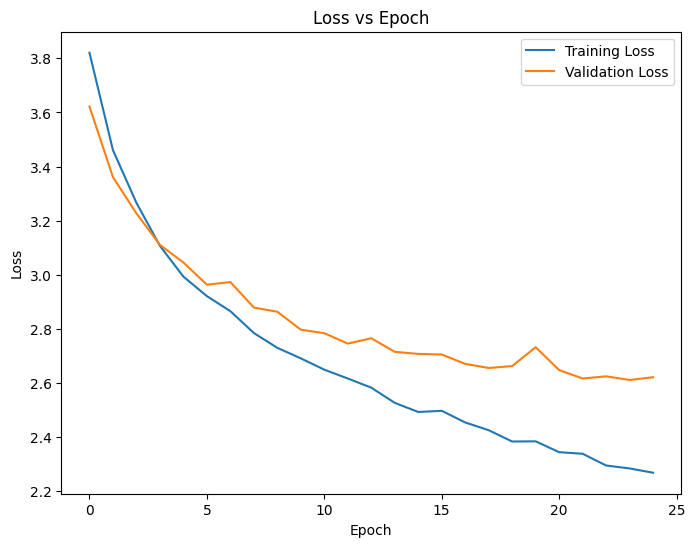

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
plt.plot(loss_data, label='Training Loss')
plt.plot(val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()


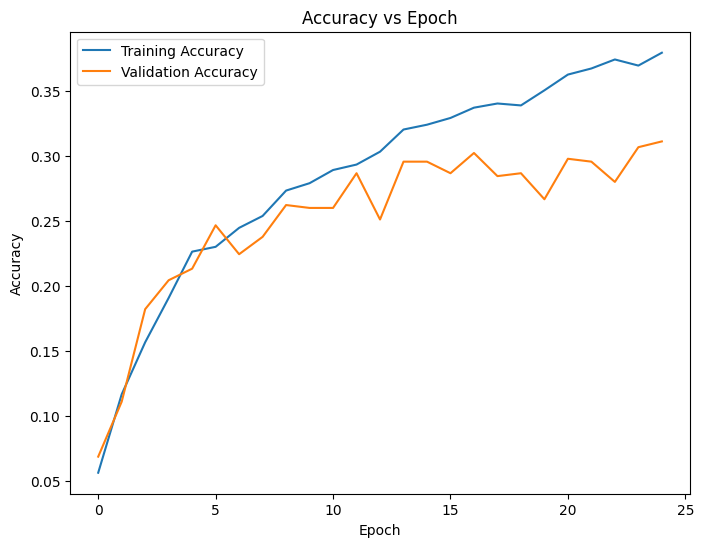

In [10]:
plt.figure(figsize=(8,6))
plt.plot(acc_data, label='Training Accuracy')
plt.plot(val_acc_data, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()
